In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import os
import shutil

In [2]:
def download(url, to_file_path):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(to_file_path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)

In [3]:
ratings_url = r'https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat'
users_url = r'https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/users.dat'
movies_url = r'https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat'

download(ratings_url, './data/ratings.dat')
download(users_url, './data/users.dat')
download(movies_url, './data/movies.dat')

In [4]:
movies_columns = ['movie_id', 'movie_title', 'genres']
movies = pd.read_csv('./data/movies.dat', sep='\:\:', header=None, names=movies_columns, engine='python')
movies.head()

,movie_id,movie_title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,91,Le manoir du diable (1896),Short|Horror


In [5]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./data/ratings.dat', sep='\:\:', header=None, names=ratings_columns, engine='python')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,user_id,movie_id,rating,timestamp,datetime
0,1,114508,8,1381006850,2013-10-05 21:00:50
1,2,499549,9,1376753198,2013-08-17 15:26:38
2,2,1305591,8,1376742507,2013-08-17 12:28:27
3,2,1428538,1,1371307089,2013-06-15 14:38:09
4,3,75314,1,1595468524,2020-07-23 01:42:04


In [6]:
n_users = len(ratings.user_id.unique())
print(f'Number of users: {n_users}')

Number of users: 70246


In [7]:
n_movies = len(ratings.movie_id.unique())
print(f'Number of movies: {n_movies}')

Number of movies: 36989


In [8]:
print('Number of reviews by year')
ratings_by_year = ratings.groupby(ratings.datetime.dt.year)['rating'].count()
ratings_by_year

Number of reviews by year


datetime
2013    170807
2014    156354
2015    123644
2016    112455
2017    105987
2018     81870
2019     74183
2020     63146
2021     10272
Name: rating, dtype: int64

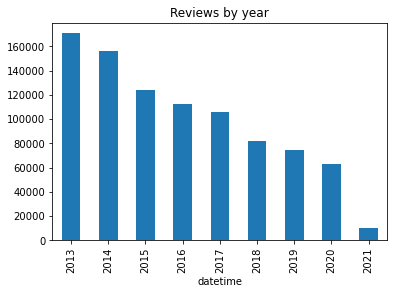

In [9]:
ratings_by_year.plot(kind='bar', title='Reviews by year', color='tab:blue')

In [10]:
print(f'Earliest review: {ratings.datetime.min()}')
print(f'Latest review: {ratings.datetime.max()}')

Earliest review: 2013-02-28 14:38:27
Latest review: 2021-03-30 22:08:05


In [11]:
# Merge ratings and movies data so to have the movie title and genres in the dataset
movie_ratings = ratings.merge(movies, on='movie_id', how='left')
movie_ratings.head(10)

,user_id,movie_id,rating,timestamp,datetime,movie_title,genres
0,1,114508,8,1381006850,2013-10-05 21:00:50,Species (1995),Action|Horror|Sci-Fi|Thriller
1,2,499549,9,1376753198,2013-08-17 15:26:38,Avatar (2009),Action|Adventure|Fantasy|Sci-Fi
2,2,1305591,8,1376742507,2013-08-17 12:28:27,Mars Needs Moms (2011),Animation|Adventure|Family|Sci-Fi
3,2,1428538,1,1371307089,2013-06-15 14:38:09,Hansel &amp; Gretel: Witch Hunters (2013),Action|Fantasy|Horror
4,3,75314,1,1595468524,2020-07-23 01:42:04,Taxi Driver (1976),Crime|Drama
5,3,102926,9,1590148016,2020-05-22 11:46:56,The Silence of the Lambs (1991),Crime|Drama|Thriller
6,3,114369,10,1597555347,2020-08-16 05:22:27,Se7en (1995),Crime|Drama|Mystery|Thriller
7,3,118715,8,1596006798,2020-07-29 07:13:18,The Big Lebowski (1998),Comedy|Crime
8,3,120737,8,1599306720,2020-09-05 11:52:00,The Lord of the Rings: The Fellowship of the R...,Adventure|Drama|Fantasy
9,3,208092,5,1586466072,2020-04-09 21:01:12,Snatch (2000),Comedy|Crime


In [12]:
# Popular movies are movies with more reviews.
print('Popular movie - Top 10 movies by number of reviews')
movie_ratings_count = movie_ratings.groupby(['movie_title']).agg(rating_count=('rating', 'count'), rating_average=('rating', 'mean')).nlargest(10, 'rating_count')
movie_ratings_count

Popular movie - Top 10 movies by number of reviews


,rating_count,rating_average
movie_title,,
Gravity (2013),3103,8.229778
Interstellar (2014),2942,8.840245
1917 (2019),2872,8.619081
The Wolf of Wall Street (2013),2833,8.389693
Joker (2019),2752,9.082485
Man of Steel (2013),2690,7.665056
World War Z (2013),2428,7.299423
Iron Man Three (2013),2414,7.675642
Now You See Me (2013),2379,7.594367


In [13]:
print('Top 10 movies by average rating (excluding movies with less than 100 reviews)')
movie_ratings_average = movie_ratings.groupby('movie_title').agg(rating_average=('rating', 'mean'), rating_count=('rating', 'count')).reset_index()
movie_ratings_average = movie_ratings_average[movie_ratings_average['rating_count'] >= 100].nlargest(10, 'rating_average')
movie_ratings_average

Top 10 movies by average rating (excluding movies with less than 100 reviews)


,movie_title,rating_average,rating_count
3370,Be Somebody (2016),9.985836,353
32400,The Shawshank Redemption (1994),9.388642,1127
31206,The Lord of the Rings: The Return of the King ...,9.353403,382
29618,The Dark Knight (2008),9.280220,728
102,12 Angry Men (1957),9.210778,835
30294,The Godfather: Part II (1974),9.131579,380
14590,It's a Wonderful Life (1946),9.128049,328
1820,Amadeus (1984),9.104938,324
28498,Terminator 2: Judgment Day (1991),9.101215,247
28102,Taare Zameen Par (2007),9.100917,109


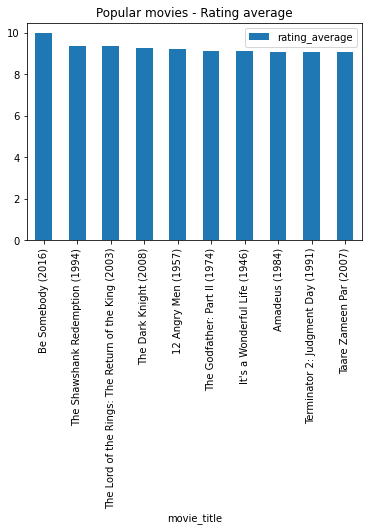

In [14]:
movie_ratings_average.plot(x='movie_title', y='rating_average', kind='bar', title='Popular movies - Rating average', color='tab:blue')

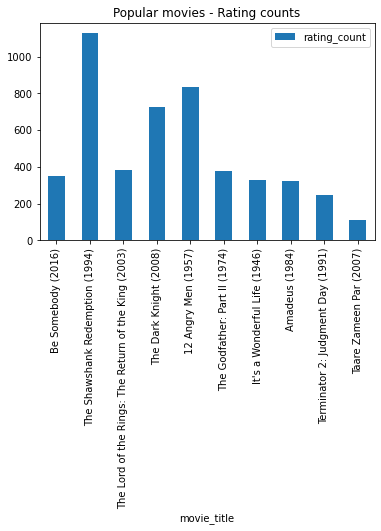

In [15]:
movie_ratings_average.plot(x='movie_title', y='rating_count', kind='bar', title='Popular movies - Rating counts', color='tab:blue')

In [16]:
movie_ratings_count = movie_ratings.groupby(['movie_title'])\
    .agg(rating_count=('rating', 'count'))\
    .reset_index()\
    .sort_values(['rating_count'], ascending=False)
movie_ratings_count.head(10)

,movie_title,rating_count
11825,Gravity (2013),3103
14374,Interstellar (2014),2942
161,1917 (2019),2872
33112,The Wolf of Wall Street (2013),2833
15117,Joker (2019),2752
18920,Man of Steel (2013),2690
36097,World War Z (2013),2428
14471,Iron Man Three (2013),2414
21558,Now You See Me (2013),2379
11677,Gone Girl (2014),2276


In [17]:
# Calculate 0.5 quantile on 'rating_count'
q50 = movie_ratings_count.rating_count.quantile(0.5)
q50

2.0

In [18]:
# Unpopular half of the movies - Movies with rating count less than the average rating count (q50 = average rating count = 2.0)
unpopular_movies = movie_ratings_count[movie_ratings_count['rating_count'] <= q50]
print(f'There are { len(unpopular_movies) } unpopular movies with average rating count less than { q50 }')
unpopular_movies.head(10)

There are 20401 unpopular movies with average rating count less than 2.0


,movie_title,rating_count
31812,The Paternal House (2012),2
20216,Mountain Cry (2015),2
10582,Fortress 2 (2000),2
3758,Beyond Evil (1980),2
3832,Bibliothèque Pascal (2010),2
31726,The Other Dream Team (2012),2
10487,Foodfight! (2012),2
20213,Mounam Pesiyadhe (2002),2
22599,Partners (1982),2
22706,Peace to Us in Our Dreams (2015),2


In [19]:
# Popular half of the movies - Movies with rating count greather than the average rating count (q50 = average rating count = 2.0)
popular_movies = movie_ratings_count[movie_ratings_count['rating_count'] > q50]
print(f'There are { len(popular_movies) } popular movies with average rating count less than { q50 }')
popular_movies.head(10)

There are 16524 popular movies with average rating count less than 2.0


,movie_title,rating_count
11825,Gravity (2013),3103
14374,Interstellar (2014),2942
161,1917 (2019),2872
33112,The Wolf of Wall Street (2013),2833
15117,Joker (2019),2752
18920,Man of Steel (2013),2690
36097,World War Z (2013),2428
14471,Iron Man Three (2013),2414
21558,Now You See Me (2013),2379
11677,Gone Girl (2014),2276


In [20]:
# Looks like there are users reviewing more than 2000 movies (probably a special Twitter account that makes movie reviews)
# Use a Twitter API to get the Twitter user name for user_id=17033, corresponding to twitter_user_id=229985772
user_review_counts = movie_ratings.groupby('user_id').agg(review_counts=('rating', 'count')).sort_values('review_counts', ascending=False).reset_index()
top10_users_by_reviews = user_review_counts.head(10)
top10_users_by_reviews

,user_id,review_counts
0,17036,2877
1,26402,2072
2,40011,1926
3,68109,1771
4,68402,1607
5,2178,1378
6,70129,1370
7,3590,1276
8,45826,1192
9,66637,1188


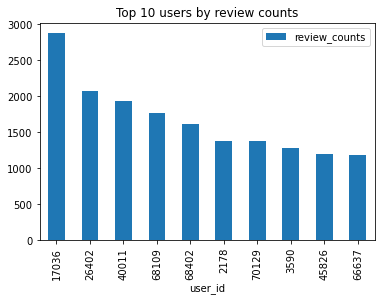

In [21]:
top10_users_by_reviews.plot(x='user_id', y='review_counts', kind='bar', title='Top 10 users by review counts', color='tab:blue')

In [22]:
users_and_reviews_count = user_review_counts.groupby('review_counts').agg(user_counts=('user_id', 'count')).sort_values('user_counts', ascending=False).reset_index()
users_and_reviews_count.head(50)

,review_counts,user_counts
0,1,30351
1,2,8667
2,3,4766
3,4,3199
4,5,2392
5,6,1956
6,7,1541
7,8,1293
8,9,1126
9,10,945


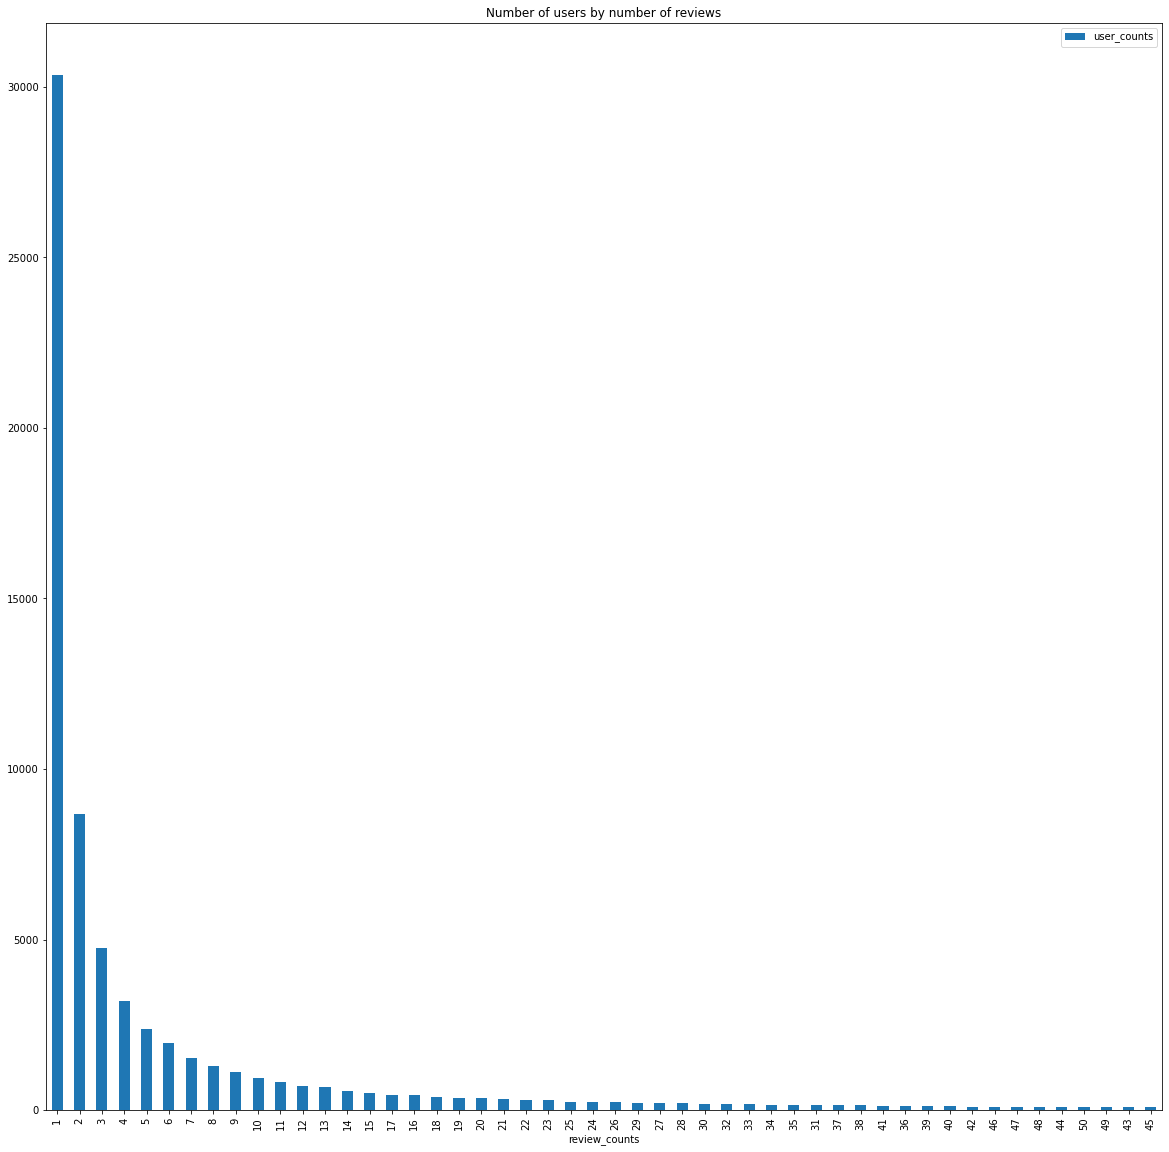

In [23]:
users_and_reviews_count.head(50)\
    .plot(x='review_counts', y='user_counts', kind='bar', title='Number of users by number of reviews', color='tab:blue', figsize=(20,20))

In [24]:
# Selecting only users with 20 reviews or more for our dataset results in using data for just a subset of users.
# Using this dataset for training a recommender system means that all other users might experience cold-start problems.
min_reviews_per_user = 20
users_more_than_min_reviews = user_review_counts[user_review_counts['review_counts'] >= min_reviews_per_user]
print(f'There are { len(users_more_than_min_reviews) } users with more than { min_reviews_per_user } which is { len(users_more_than_min_reviews) / n_users * 100 }% of all users')
users_more_than_min_reviews.head(10)

There are 9066 users with more than 20 which is 12.906072943655156% of all users


,user_id,review_counts
0,17036,2877
1,26402,2072
2,40011,1926
3,68109,1771
4,68402,1607
5,2178,1378
6,70129,1370
7,3590,1276
8,45826,1192
9,66637,1188


In [25]:
#  Eligible users are users who have at least 'min_reviews_per_user'reviews in teh dataset
eligible_users = users_more_than_min_reviews['user_id']

In [26]:
# Having the list of users we would like to use we can create both a training set and a test set.
# The training set will be used to create a validation set too, while the test set will be held out and used at the end to evaluate the performance of the final recommender.

In [27]:
ratings_data = movie_ratings[movie_ratings['user_id'].isin(eligible_users)]
print(f'Original dataset size: { len(movie_ratings) }. New dataset size: { len(ratings_data) }. Percentage: { len(ratings_data) / len(movie_ratings) * 100}')
ratings_data.head(10)

Original dataset size: 900365. New dataset size: 690377. Percentage: 76.67745858624002


,user_id,movie_id,rating,timestamp,datetime,movie_title,genres
4,3,75314,1,1595468524,2020-07-23 01:42:04,Taxi Driver (1976),Crime|Drama
5,3,102926,9,1590148016,2020-05-22 11:46:56,The Silence of the Lambs (1991),Crime|Drama|Thriller
6,3,114369,10,1597555347,2020-08-16 05:22:27,Se7en (1995),Crime|Drama|Mystery|Thriller
7,3,118715,8,1596006798,2020-07-29 07:13:18,The Big Lebowski (1998),Comedy|Crime
8,3,120737,8,1599306720,2020-09-05 11:52:00,The Lord of the Rings: The Fellowship of the R...,Adventure|Drama|Fantasy
9,3,208092,5,1586466072,2020-04-09 21:01:12,Snatch (2000),Comedy|Crime
10,3,358273,9,1579057827,2020-01-15 03:10:27,Walk the Line (2005),Biography|Drama|Music|Romance
11,3,477348,6,1597289003,2020-08-13 03:23:23,No Country for Old Men (2007),Crime|Drama|Thriller
12,3,10039344,5,1578603053,2020-01-09 20:50:53,Countdown (2019),Horror|Thriller
13,3,1051906,6,1589924916,2020-05-19 21:48:36,The Invisible Man (2020),Horror|Sci-Fi|Thriller


In [28]:
# For each user with at least 20 reviews we take the last two reviews (by timestamp) in the test set.
test_data = ratings_data[ratings_data['user_id'].isin(eligible_users)]\
    .sort_values(['user_id', 'timestamp'], ascending=[True, False])\
    .groupby('user_id', as_index=False).apply(lambda df: df.iloc[:2])
test_data

user_id  movie_id  rating   timestamp            datetime  \
0    17            3   6723592       8  1599578941 2020-09-08 15:29:01   
     8             3    120737       8  1599306720 2020-09-05 11:52:00   
1    195          38   7286456       9  1572535618 2019-10-31 15:26:58   
     193          38   6320628      10  1562130981 2019-07-03 05:16:21   
2    250          46   4154796      10  1556355954 2019-04-27 09:05:54   
...              ...       ...     ...         ...                 ...   
9063 900109    70233   4154664       4  1551998990 2019-03-07 22:49:50   
9064 900203    70241   1396484       8  1505077617 2017-09-10 21:06:57   
     900234    70241   2771200       8  1501881885 2017-08-04 21:24:45   
9065 900286    70244  10272386       2  1616969903 2021-03-28 22:18:23   
     900327    70244   6802400       3  1616893241 2021-03-28 01:00:41   

                                                   movie_title  \
0    17                                           Tenet (2020)   
     8       The Lord of the Rings: The Fellowship of the R...   
1    195                                          Joker (2019)   
     193                      Spider-Man: Far from Home (2019)   
2    250                              Avengers: Endgame (2019)   
...                                                        ...   
9063 900109                              Captain Marvel (2019)   
9064 900203                                          It (2017)   
     900234                        Beauty and the Beast (2017)   
9065 900286                                  The Father (2020)   
     900327                            Coming 2 America (2021)   

                                      genres  
0    17                Action|Drama|Thriller  
     8               Adventure|Drama|Fantasy  
1    195                Crime|Drama|Thriller  
     193      Action|Adventure|Comedy|Sci-Fi  
2    250     Action|Adventure|Fantasy|Sci-Fi  
...                                      ...  
9063 900109          Action|Adventure|Sci-Fi  
9064 900203                  Horror|Thriller  
     900234   Family|Fantasy|Musical|Romance  
9065 900286                            Drama  
     900327                           Comedy  

[18132 rows x 7 columns]

In [29]:
remaining_data = ratings_data[ratings_data['user_id'].isin(eligible_users)]\
    .sort_values(['user_id', 'timestamp'], ascending=[True, False])\
    .groupby('user_id', as_index=False)\
    .apply(lambda df: df.iloc[2:])
remaining_data

user_id  movie_id  rating   timestamp            datetime  \
0    6             3    114369      10  1597555347 2020-08-16 05:22:27   
     14            3   1568346       6  1597388722 2020-08-14 07:05:22   
     15            3   2278388       8  1597297732 2020-08-13 05:48:52   
     11            3    477348       6  1597289003 2020-08-13 03:23:23   
     7             3    118715       8  1596006798 2020-07-29 07:13:18   
...              ...       ...     ...         ...                 ...   
9065 900346    70244   8623904       4  1579991512 2020-01-25 22:31:52   
     900290    70244  11390036       3  1579642212 2020-01-21 21:30:12   
     900285    70244  10039344       3  1579385451 2020-01-18 22:10:51   
     900325    70244   6450804       4  1579301031 2020-01-17 22:43:51   
     900313    70244   5727208       5  1578779457 2020-01-11 21:50:57   

                                        movie_title  \
0    6                                 Se7en (1995)   
     14      The Girl with the Dragon Tattoo (2011)   
     15             The Grand Budapest Hotel (2014)   
     11               No Country for Old Men (2007)   
     7                      The Big Lebowski (1998)   
...                                             ...   
9065 900346                   Last Christmas (2019)   
     900290                A Fall from Grace (2020)   
     900285                        Countdown (2019)   
     900325            Terminator: Dark Fate (2019)   
     900313                       Uncut Gems (2019)   

                                          genres  
0    6              Crime|Drama|Mystery|Thriller  
     14             Crime|Drama|Mystery|Thriller  
     15             Adventure|Comedy|Crime|Drama  
     11                     Crime|Drama|Thriller  
     7                              Comedy|Crime  
...                                          ...  
9065 900346                 Comedy|Drama|Romance  
     900290                             Thriller  
     900285                      Horror|Thriller  
     900325              Action|Adventure|Sci-Fi  
     900313  Comedy|Crime|Drama|Mystery|Thriller  

[672245 rows x 7 columns]

In [30]:
# For each user with at least 20 reviews we take the last two reviews (by timestamp) from the remaining reviews in the validation set.
validation_data = remaining_data[remaining_data['user_id'].isin(eligible_users)]\
    .sort_values(['user_id', 'timestamp'], ascending=[True, False])\
    .groupby('user_id', as_index=False).apply(lambda df: df.iloc[:2])
validation_data

user_id  movie_id  rating   timestamp            datetime  \
0    0    6             3    114369      10  1597555347 2020-08-16 05:22:27   
          14            3   1568346       6  1597388722 2020-08-14 07:05:22   
1    1    192          38   6146586       8  1562021752 2019-07-01 22:55:52   
          194          38   6565702       5  1561415469 2019-06-24 22:31:09   
2    2    226          46   1365519       7  1521237831 2018-03-16 22:03:51   
...                   ...       ...     ...         ...                 ...   
9063 9063 900116    70233   4463816       7  1526169118 2018-05-12 23:51:58   
9064 9064 900191    70241    758730       5  1500838221 2017-07-23 19:30:21   
          900255    70241   3622110       6  1497655046 2017-06-16 23:17:26   
9065 9065 900307    70244   4761112       7  1615784609 2021-03-15 05:03:29   
          900357    70244   9770150       3  1613944899 2021-02-21 22:01:39   

                                                movie_title  \
0    0    6                                    Se7en (1995)   
          14         The Girl with the Dragon Tattoo (2011)   
1    1    192      John Wick: Chapter 3 - Parabellum (2019)   
          194                           Dark Phoenix (2019)   
2    2    226                            Tomb Raider (2018)   
...                                                     ...   
9063 9063 900116                            Terminal (2018)   
9064 9064 900191  AVPR: Aliens vs Predator - Requiem (2007)   
          900255                   Don't Knock Twice (2016)   
9065 9065 900307                     The Mauritanian (2021)   
          900357                           Nomadland (2020)   

                                             genres  
0    0    6            Crime|Drama|Mystery|Thriller  
          14           Crime|Drama|Mystery|Thriller  
1    1    192                 Action|Crime|Thriller  
          194               Action|Adventure|Sci-Fi  
2    2    226     Action|Adventure|Fantasy|Thriller  
...                                             ...  
9063 9063 900116               Crime|Drama|Thriller  
9064 9064 900191      Action|Horror|Sci-Fi|Thriller  
          900255                             Horror  
9065 9065 900307                     Drama|Thriller  
          900357                              Drama  

[18132 rows x 7 columns]

In [31]:
# For each user with at least 20 reviews we take the remaining reviews, not in the test set or in the validation set, end up in the training set.
train_data = remaining_data[remaining_data['user_id'].isin(eligible_users)]\
    .sort_values(['user_id', 'timestamp'], ascending=[True, False])\
    .groupby('user_id', as_index=False).apply(lambda df: df.iloc[2:])
train_data

user_id  movie_id  rating   timestamp            datetime  \
0    0    15            3   2278388       8  1597297732 2020-08-13 05:48:52   
          11            3    477348       6  1597289003 2020-08-13 03:23:23   
          7             3    118715       8  1596006798 2020-07-29 07:13:18   
          4             3     75314       1  1595468524 2020-07-23 01:42:04   
          5             3    102926       9  1590148016 2020-05-22 11:46:56   
...                   ...       ...     ...         ...                 ...   
9065 9065 900346    70244   8623904       4  1579991512 2020-01-25 22:31:52   
          900290    70244  11390036       3  1579642212 2020-01-21 21:30:12   
          900285    70244  10039344       3  1579385451 2020-01-18 22:10:51   
          900325    70244   6450804       4  1579301031 2020-01-17 22:43:51   
          900313    70244   5727208       5  1578779457 2020-01-11 21:50:57   

                                      movie_title  \
0    0    15      The Grand Budapest Hotel (2014)   
          11        No Country for Old Men (2007)   
          7               The Big Lebowski (1998)   
          4                    Taxi Driver (1976)   
          5       The Silence of the Lambs (1991)   
...                                           ...   
9065 9065 900346            Last Christmas (2019)   
          900290         A Fall from Grace (2020)   
          900285                 Countdown (2019)   
          900325     Terminator: Dark Fate (2019)   
          900313                Uncut Gems (2019)   

                                               genres  
0    0    15             Adventure|Comedy|Crime|Drama  
          11                     Crime|Drama|Thriller  
          7                              Comedy|Crime  
          4                               Crime|Drama  
          5                      Crime|Drama|Thriller  
...                                               ...  
9065 9065 900346                 Comedy|Drama|Romance  
          900290                             Thriller  
          900285                      Horror|Thriller  
          900325              Action|Adventure|Sci-Fi  
          900313  Comedy|Crime|Drama|Mystery|Thriller  

[654113 rows x 7 columns]

In [34]:
(len(test_data) + len(train_data) + len(validation_data)) == len(ratings_data)

True

In [33]:
header = ['user_id', 'movie_id', 'rating', 'timestamp', 'datetime', 'movie_title', 'genres']
train_data.to_csv('./data/ratings_train.csv', sep=';', index=False, header=header)
validation_data.to_csv('./data/ratings_validation.csv', sep=';', index=False, header=header)
test_data.to_csv('./data/ratings_test.csv', sep=';', index=False, header=header)